In [6]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import pdb
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class LoadDataset(Dataset):
    def __init__(self, years=range(2016,2019), horizon=5,lookback=60,transform=None):
        """
        Args:
            years (list): List of years for which the data is to be loaded
        """
        # years = range(2010,2019)
        # dfs = (pd.read_csv("http://pjm.com/pub/account/loadhryr/%s.txt"%str(yr)) for yr in years)
        dfs = (pd.read_csv("/Users/kai/Downloads/Energy-EVT-master/load/%s.txt"%str(yr),
                           usecols=[0,1,2],names=["date","hour","load"],header=0) for yr in years)
        load_df   = pd.concat(dfs, ignore_index=True)
        load_df.date = pd.to_datetime(load_df.date, format='%m/%d/%y')
        load_df.hour = pd.to_numeric(load_df.hour/100, downcast="integer")
        load_df['dow'] = load_df.date.dt.dayofweek
        load_df['month'] = load_df.date.dt.month
        self.data = torch.tensor(load_df.sort_values(by=["date","hour"]).values[:,(1,3,4,2)].astype(int), device="cpu", dtype=torch.float32)
        # pdb.set_trace()
        self.std = self.data[:,3].std()
        self.mean = self.data[:,3].mean()
        self.min = self.data[:,3].min()
        self.max = self.data[:,3].max()
        # self.data[:,3] = (self.data[:,3] - self.min)/(self.max - self.min)
        self.data[:,3] = (self.data[:,3] - self.mean)/(self.std)
        self.horizon = horizon
        self.lookback = lookback
        self.transform = transform
    def __len__(self):
        return len(self.data)-self.lookback-self.horizon
    def __getitem__(self,idx):
        # pdb.set_trace()
        current = self.data[idx+self.lookback+self.horizon-1,3]
        # past    = torch.cat([self.data[idx:(idx+self.lookback),3],self.data[idx+self.lookback+self.horizon-1,0:3]])
        past    = torch.tensor(self.data[idx:(idx+self.lookback),3])
        # print(past.size())
        sample = {'past': past, 'current': current}
        if self.transform:
            sample = self.transform(sample)
        return sample	




# for i_batch, sample_batched in enumerate(dataloader):
# 	print(i_batch, sample_batched)
# 	if i_batch==3:
# 		break

class EVT(nn.Module):
    def __init__(self, nin, hidden_sizes, nout):
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        # pdb.set_trace()
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([nn.Linear(h0, h1),nn.Tanh()])
        self.net.pop() # pop the last nonlinear function for the output layer, just make it linear
        self.net = nn.Sequential(*self.net)
        self.net.apply(self.initweights)
        self.xi = torch.tensor([1e-3], device=device, dtype=dtype, requires_grad=True)
    def initweights(self,m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='tanh')
    def forward(self, x):
        y = self.net(x)
        # return self.xi,y[:,0].exp()
        # return self.xi,y[:,0].clamp(min=1e-6)
        return y[:,0].tanh().exp(), self.xi


In [7]:
# for seed in range(20,60):
seed = 39
torch.manual_seed(seed)
hidden = [3]
learning_rate = 1e-2
u = 31000
nepoch =15
nin = 36


td = LoadDataset(lookback=nin)
dataloader = DataLoader(td, batch_size=128, num_workers=0)



In [8]:
td.data

tensor([[  1.0000,   4.0000,   1.0000,  -0.8791],
        [  2.0000,   4.0000,   1.0000,  -1.0251],
        [  3.0000,   4.0000,   1.0000,  -1.1379],
        ...,
        [ 22.0000,   1.0000,   5.0000,  -0.2205],
        [ 23.0000,   1.0000,   5.0000,  -0.6421],
        [ 24.0000,   1.0000,   5.0000,  -1.0357]])

Epoch 0:  -0.6013960242271423
Epoch 1:  -0.6015834212303162
Epoch 2:  -0.6011939644813538
Epoch 3:  -0.6022868752479553
Epoch 4:  -0.6023133993148804
Epoch 5:  -0.6023260354995728
Epoch 6:  -0.6023381352424622
Epoch 7:  -0.6023445725440979
Epoch 8:  -0.6023073196411133
Epoch 9:  -0.602236270904541
Epoch 10:  -0.6021115183830261
Epoch 11:  -0.6018803715705872
Epoch 12:  -0.6018617749214172
Epoch 13:  -0.6010783314704895
Epoch 14:  -0.6001269221305847


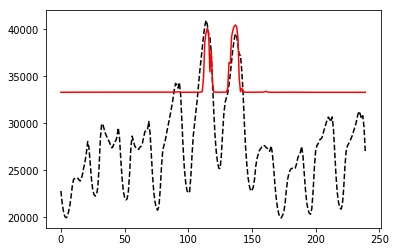

In [9]:
dtype = torch.float32
device = torch.device("cpu")
nout = 1
model = EVT(nin,hidden,nout)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)
# optimizer = torch.optim.Adam(list(model.parameters()) + [model.xi],lr=learning_rate)
loss_func = torch.nn.MSELoss() 
# u = (u - td.min)/(td.max - td.min)
u = ((u - td.mean)/(td.std)).item()
nBtrain = int(len(td)/dataloader.batch_size*0.98)
for epoch in range(nepoch):
    for i, sample_batched in enumerate(dataloader):
        # sample_batched = next(enumerate(dataloader))[1]
        x,y = sample_batched["past"], sample_batched["current"]
        g,xi = model(x)

        ###### Model with nonzero xi ########
        # tmp = (1+g.pow(-1)*xi*(y-u)).clamp(min=1e-8)
        # ll = -g.log() - (xi.pow(-1)+1)*tmp.log()

        ###### Model with xi -> 0 ########
        ll = -g.log() - g.pow(-1)*(y-u)

        indicator = (y-u) > 0
        indicator = indicator.nonzero()
        # pdb.set_trace()
        # 
        if indicator.shape[0]==0:
            continue
        loss = -(ll[indicator[:,0]]).mean() #only use samples with y > u
        # loss = -(ll).mean() # use all samples
        # loss = loss_func(g, y) 
        if np.isnan(loss.item()):
            pdb.set_trace()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i==nBtrain:
            break
    print("Epoch %s: "%epoch, loss.item())

# print(xi.item())
# test_ind = range(nBtrain*dataloader.batch_size, len(td))
test_ind = range(len(td)-240, len(td))
n = len(test_ind)
y = np.zeros(n)
yhat = np.zeros(n)
for i in range(n):
    yhat[i] = model(torch.tensor(td[test_ind[i]]["past"]).unsqueeze(0))[0].item()
    y[i] = td[test_ind[i]]["current"].item()
t = np.array(range(n))

# plt.plot(t, td.std.item()*y.astype(np.float32)+td.mean.item(), 'k--', t, td.std.item()*(u+yhat.astype(np.float32)/(1-xi.item()))+td.mean.item(), 'r-')
plt.figure()
plt.plot(t, td.std.item()*y.astype(np.float32)+td.mean.item(), 'k--', t, td.std.item()*(u+yhat.astype(np.float32))+td.mean.item(), 'r-')
plt.savefig(str(seed)+"_evt.png")


# model(torch.tensor(td[10]["past"]).unsqueeze(0))
# model(torch.tensor(td[40]["past"]).unsqueeze(0))


